# Assignment 2
#### Group 18
s234829 - Mia Isbella Lund <br>
s204120 - Kristian Mathies Friis Nielsen <br>
s247370 - Malika Eden d'Sa 


Git repository: <br>
https://github.com/s234829/-02467_assignments

Group members' main contributions: <br>
Kristian: part 1 <br>
Mia: part 2 <br>
Malika: part 3


## Part 1: Properties of the real-world network of Computational Social Scientists

In [2]:
import pandas as pd
import networkx as nx
import json
from networkx.readwrite import json_graph
import numpy as np
from scipy import stats
import ast
import netwulf

1. Random Network: Let's start by building a Random Network, acting as a baseline (or "null model") to understand the Computational Social Scientists Network better.

In [3]:
# Opening the Social Science graph from Week 4 for use later:
with open("network.json", "r") as f:
    graph_data = json.load(f)

# Convert the data back into a NetworkX graph object
Graph = json_graph.node_link_graph(graph_data)

* First, calculate the probability (p) that makes the expected number of edges in our random network match the actual edge count in the Computational Social Scientists network. Refer to equation 3.2 in your Network Science textbook for guidance. After finding p, figure out the average degree (using the given formula).

The formula for p is given by:

$$L = p \cdot \frac{N(N-1)}{2}$$

Average edge count is then:

$$k = \frac{2\cdot L}{N}$$

In [4]:
num_nodes = Graph.number_of_nodes()
num_edges = Graph.number_of_edges()

#Solve for p using formula:
Lmax = num_nodes * (num_nodes - 1) / 2  
p = num_edges / Lmax  
print(f"Calculated probability p: {p}")

#Find k using formula
average_degree = (2 * num_edges) / num_nodes
print(f"Average degree: {average_degree}")

Calculated probability p: 0.0005212759472531752
Average degree: 7.871266803522945


* Now, write a function to generate a Random Network that mirrors the Computational Social Scientists network in terms of node count, using your calculated p. Generate a random network by linking nodes in every possible pair with probability p. Hint: you can use the function np.random.uniform to draw samples from a uniform probability distribution.

In [5]:
def random_network(n, p):
    """
    input:
    n = number of nodes
    p = probability
    outputs:
    Graph: random graph with n amount of nodes
    """
    Graph = nx.Graph()
    Graph.add_nodes_from(range(n))
    
    for i in range(n):
        for j in range(i+1,n):
            if p > np.random.uniform(0,1):
                Graph.add_edge(*(i,j))
    
    return Graph

random_graph = random_network(num_nodes,p)

Visualize the network as you did for the Computational Social Scientists network in the exercise above

In [6]:
for node, data in Graph.nodes(data=True):
    country_value = data.get('country', 'none')
    data['group'] = country_value #Use built in color functionality
    
#config doesn't actually seem to do anything...
netwulf.visualize(
    Graph,
    config={
        'colorPalette': 'category10',  # Use distinct colors
        'zoom': 0.6,
        'nodeCharge': -50,
        'gravity': 0.25
    }
)#Use: Size by strength; Node size 50.

(None, None)

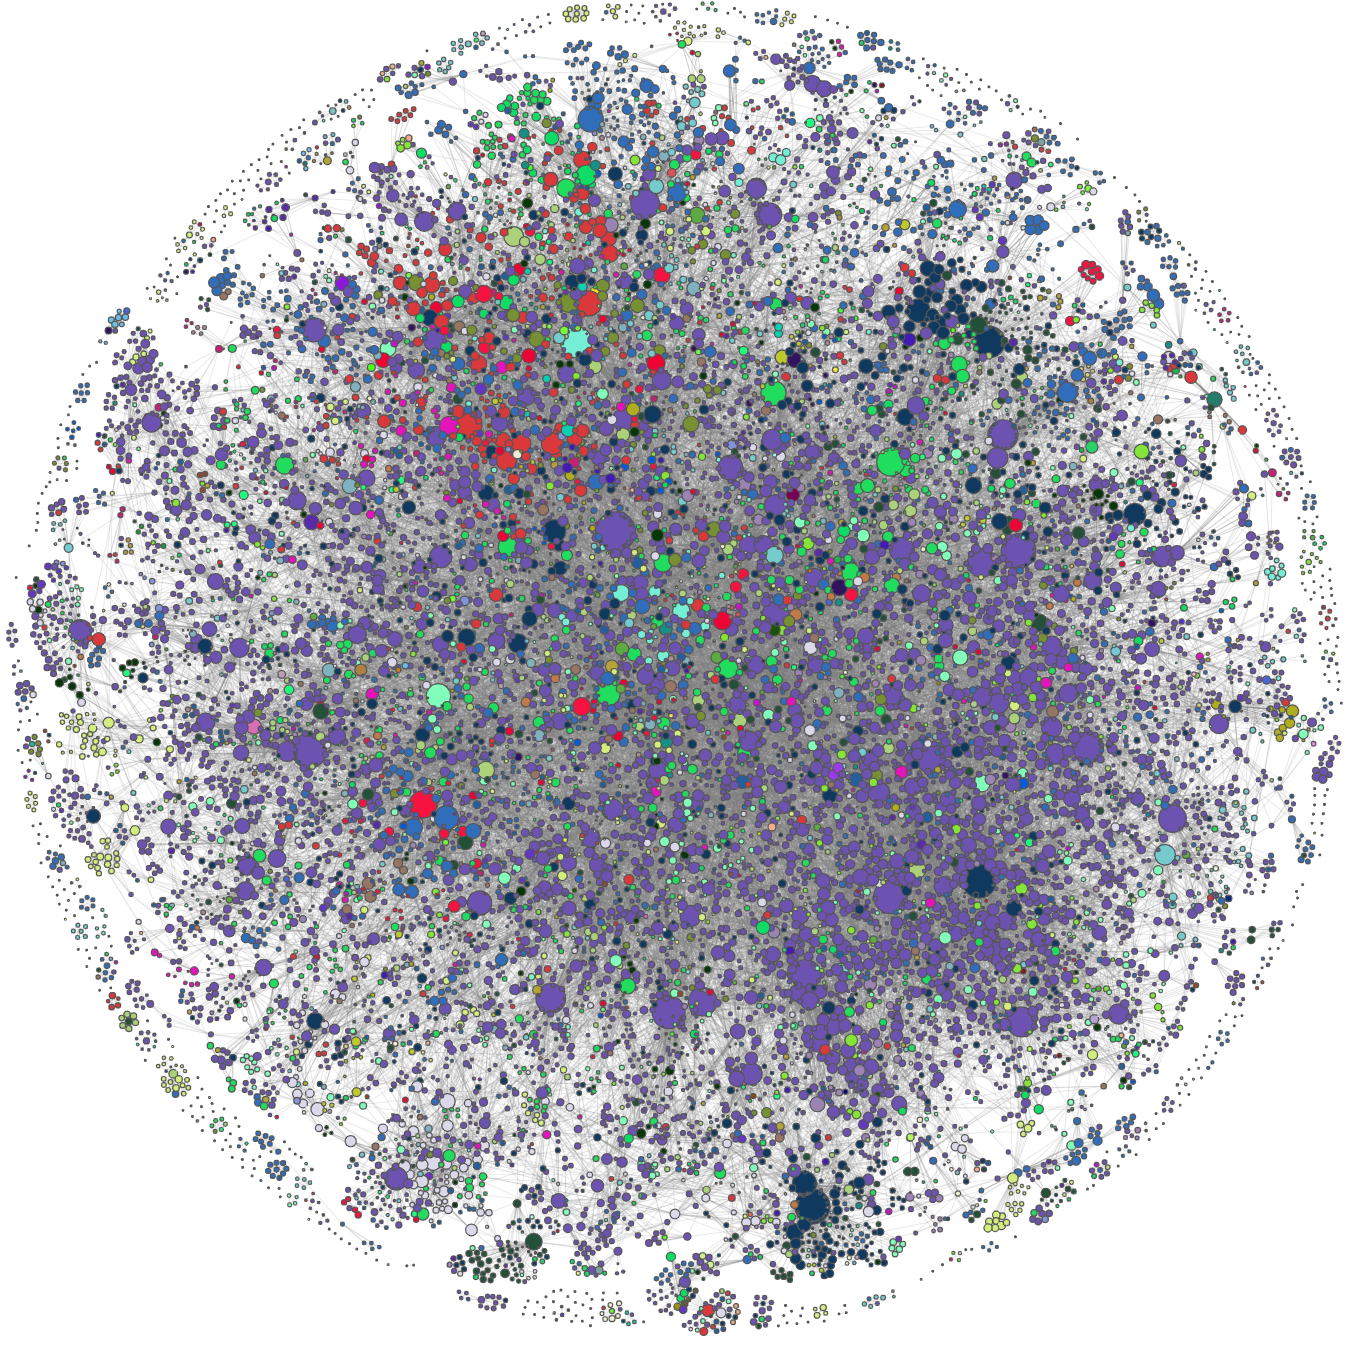

In [7]:
netwulf.visualize(random_graph) # Random graph

(None, None)

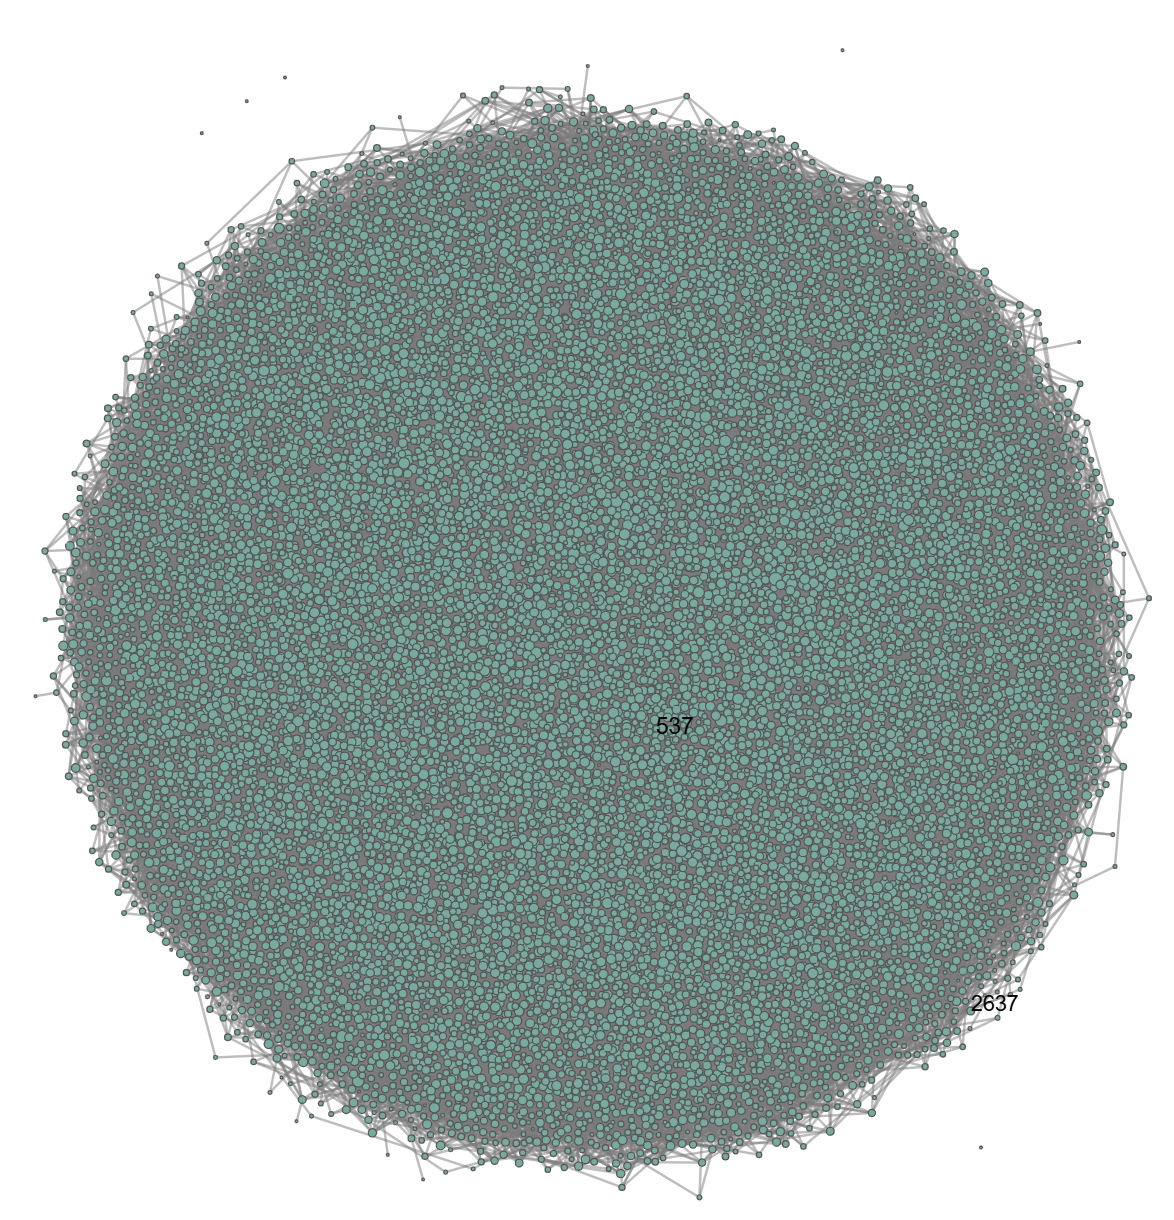

* What regime does your random network fall into? Is it above or below the critical threshold? <br>
* According to the textbook, what does the network's structure resemble in this regime? <br>

In section 3.6 is denoted the "Giant Component". This is a large connected component or sub-network that is as the name suggests has a significant number of the nodes in a random network. There is a critical threshold given:

$p_c \sim \frac{1}{N}$ (3.11)

Where, this cluster will emerge for $p > p_c$

In [8]:
critical_point = 1/num_nodes
print(critical_point)
p > critical_point

6.622078008078935e-05


True

Since p is well above $p_c$, and average degree is well above 1 (3.10), the network falls into the "Supercritical Regime", as the average edge count is not quite large enough to be Connected:

In [9]:
np.log(num_nodes)

9.62251624577579

* Based on your visualizations, identify the key differences between the actual and the random networks. Explain whether these differences are consistent with theoretical expectations.

It's evident that the real network has an "inner" Giant Cluster (Component) whereas the random graph is uniform. The real network has a smaller "halo" around its periphery, these are the authors with very few co-authored papers and we can spot small clusterings where a small group of authors have collaborated together in 'isolation' 

Here, the nodes are scaled to strength so bigger nodes are authors with *many* co-authored papers, and it's evident that a handful of nodes dominate the graph making it consistent with the power-law distribution of edge counts.

Visually therefore we can spot: The large connected component, evidence of the small world property and a heavy right tailed distribution on edge-counts.

### 2. Shortest Paths: Here, we will check if the Computational Social Scientists Network exhibits characteristics of a small-world network by analyzing its shortest paths.

* Begin by identifying the largest connected component within the Computational Social Scientists network. Recall that a connected component is a subset of nodes in which every pair of nodes is connected by a path. For a refresher on connected components, see section 2.9 of the Network Science book. Follow these steps:
    * Utilize nx.algorithms.connected_components to enumerate all connected components, which will be returned as a list of node subsets.
    * Select the largest subset of nodes identified in the previous step. Then, create a subgraph of your original network that includes only these nodes, using nx.Graph.subgraph. This subset forms your largest connected component, sometimes referred to as the giant component.

In [10]:
#list of connected components:
connected_components = list(nx.connected_components(Graph))
#Finding the biggest set, from the list:
largest_component = max(connected_components, key=len)
giant_component = Graph.subgraph(largest_component)

* Calculate the average (unweighted) shortest path length within this giant component by employing nx.average_shortest_path_length.

In [11]:
# The algorithm here is of O^3 complexity. We've used an approximation instead
# Which can be seen below:

#avg_len = nx.average_shortest_path_length(giant_component)
#print(f"Average shortest path length for the giant component: {avg_len}")

In [12]:
import random
#Algortihm that approximates the shortest path lengths:
def sample_shortest_paths(graph, num_samples):
    nodes = list(graph.nodes())
    total_path_length = 0
    count = 0
    
    for _ in range(num_samples):
        node1, node2 = random.sample(nodes, 2)
        try:
            path_length = nx.shortest_path_length(graph, source=node1, target=node2)
            total_path_length += path_length
            count += 1
        except nx.NetworkXNoPath:
            continue  

    if count > 0:
        return total_path_length / count
    else:
        return float('inf') 

In [13]:
approx_average_path = sample_shortest_paths(giant_component, 10000)
print("Approximated average shortest path - SoSci LC:", approx_average_path)

Approximated average shortest path - SoSci LC: 5.2122


* Perform the same calculation for the giant component of the random network you constructed in the above exercise 1.

In [14]:
#Same procedure for the random graph:
connected_components = list(nx.connected_components(random_graph))
largest_component = max(connected_components, key=len)
giant_component_rnd = random_graph.subgraph(largest_component)

In [15]:
approx_average_path = sample_shortest_paths(giant_component_rnd, 10000)
print("Approximated average shortest path - Rnd LC:", approx_average_path)

Approximated average shortest path - Rnd LC: 4.8668


* Reflect on how the average shortest path lengths of the real and random networks compare and answer the following questions, supporting your answers with the theory from the book. <br>
    * Why do you think I asked you to consider the giant component only? <br>
    * Why do you think I asked you to consider unweighted edges? <br>
    * Does the Computational Social Scientists network exhibit the small-world phenomenon? <br>

Calculating average distance (3:19) and cluster coefficients to support the answers to the questions above:

In [16]:
def average_dist_approximation(graph):
    N = graph.number_of_nodes()
    avg_degree = sum(dict(graph.degree()).values()) / N
    avg_shortest_path = np.log(N) / np.log(avg_degree)
    return avg_shortest_path

approx_shortest_path_real = average_dist_approximation(giant_component)
approx_shortest_path_rnd = average_dist_approximation(giant_component_rnd)

print(f"Approx distance in the Soc Sci Network: {approx_shortest_path_real}")
print(f"Approx distance in the Randomized Network: {approx_shortest_path_rnd}")

real_clustering = nx.average_clustering(Graph)
print(f"Global Clustering Coefficient of Real Network: {real_clustering}")

random_clustering = nx.average_clustering(random_graph)
print(f"Global Clustering Coefficient of Random Network: {random_clustering}")

Approx distance in the Soc Sci Network: 4.540601588072172
Approx distance in the Randomized Network: 4.644416417280641
Global Clustering Coefficient of Real Network: 0.6743495300569378
Global Clustering Coefficient of Random Network: 0.0005127249487135886


*Social Science Graph*

The reason why we might be interested in the giant components primarily, is because we saw in the previous exercise (not part of the assignment), the Social Scientists network exhibits a heavy right-tailed distribution such that, the vast majority of nodes in the network are either isolated in small groups, or with relatively few connections. But there is a substantial amount of nodes with very high edge count - hence the extreme right tail. 

In terms of focussing on the Giant Component, we therefore focus on the general real-world network structure and omit the isolated nodes. These don't contribute much to the structure of the network that constitutes most of the behavior of the nodes with very high edge count.

We've also calculated the approximate, average distance (3.19) and see that it is close to the calculated average shortest path between nodes. We can therefore say with high certainty that the network does exhibit the small-world property since, in spite of the large number of nodes <5 steps are typically needed for two nodes to reach eachother.

*The Random Graph*

We might be inclined to also believe the random network exhibits the same behavior since it also has an average distance that is close to the average observed shortest path lenght - and indeed both networks have similar figures here. 

But using the extension of the "Small world property" definition (Box 3.9) we observe that the clustering coefficient for the random network is much, much smaller (as can be seen in the output from the code chunk above).

This indicates that while the random network is also highly connected, it does not form the same type of close clustering where there is a high density of interconnected nodes within the largest component. 

Therefore the random network doesn't fit the Small worlds property.

*Unweighed Edges*

Generally we avoid using node strengths here because we are mainly interested in the physical structure of the networks, and how the random network differs from the real-world one of Social Scientists. Using unweighed edges allows us to make these comparisons directly to investigate the small-world property.


## Part 2 Network Analysis in Computational Social Science

In [18]:
import json
import networkx as nx
from networkx.readwrite import json_graph
import numpy as np
import random
import netwulf as nw
import matplotlib.pyplot as plt

### Exercise 1: Mixing Patterns and Assortativity

### Part 1: Assortativity Coefficient

1. Calculate the Assortativity Coefficient for the network based on the country of each node. Implement the calculation using the formula provided during the lecture, also available in this paper (equation 2, here for directed networks). Do not use the NetworkX implementation.

In [19]:
with open("network.json", "r") as f:
    graph_data = json.load(f)
Graph = json_graph.node_link_graph(graph_data)
Graph.number_of_edges(), Graph.number_of_nodes()

(59432, 15101)

In [26]:
def assortativity_coeffient(G, attribute):
    e = nx.attribute_mixing_matrix(G,attribute)
    eii = 0
    ai_bi = 0
    for i in range(e.shape[0]):
        eii += e[i][i]
        ai = sum(e[i])
        bi = sum(e[:,i])
        ai_bi += ai*bi

    r = (eii-ai_bi)/(1-ai_bi)
    return r
r_real = assortativity_coeffient(Graph,"country")
r_real

0.3412524597921108

check with nx function if it is correct

In [27]:
nx.attribute_assortativity_coefficient(Graph, "country")

0.3412524597921108

### Part 2: Configuration model
In the following, we are going to assess the significance of the assortativity by comparing the network's assortativity coefficient against that of random networks generated through the configuration model.  

2. *Implement the configuration model* using the _double edge swap_ algorithm to generate random networks. Ensure each node retains its original degree but with altered connections. Create a function that does that by following these steps:
- **a.** Create an exact copy of your original network.
- **b.** Select two edges, $e_{1} = (u,v)$ and $e_{2} = (x,y)$, ensuring *u != y* and *v != x*.
- **c.** Flip the direction of $e_{1}$ to $e_{1} = (v,u)$ 50% of the time. This ensure that your final results is not biased, in case your edges were sorted (they usually are). 
- **d.** Ensure that new edges $e_{1}' = (e_{1}[0],e_{2}[1])$ and $e_{2}' = (e_{2}[0],e_{1}[1])$ do not already exist in the network.
- **e.** Remove edges $e_{1}$ and $e_{2}$ and add edges $e_{1}'$ and $e_{2}'$.
- **f.** Repeat steps **b** to **e** until you have performed _E*10_ swaps, where E is the total number of edges.

In [28]:
def double_edge_swap(G):
    """
    input:
    G: nx.graph
    output:
    copy of orginal graph 
    """
    copy = G.copy() # Create an exact copy of your original network
    nswaps = 10 * copy.number_of_edges()  
    n = 0
    
    nodes = list(copy.nodes())  # Work with nodes instead of edges

    while n < nswaps:
        # Pick two random nodes
        u, x = random.sample(nodes, 2)
        
        # Ensure both nodes have at least one neighbor
        if not list(copy.neighbors(u)) or not list(copy.neighbors(x)):
            continue
        
        # Pick one neighbor each
        v = random.choice(list(copy.neighbors(u)))
        y = random.choice(list(copy.neighbors(x)))
        
        # Avoid self-loops or redundant edges
        if u == y or x == v or copy.has_edge(u, y) or copy.has_edge(x, v):
            continue
        
        # Perform the swap
        copy.remove_edge(u, v)
        copy.remove_edge(x, y)
        copy.add_edge(u, y)
        copy.add_edge(x, v)

        n += 1
    
    return copy


3. *Double check that your algorithm works well*, by showing that the degree of nodes in the original network and the new 'randomized' version of the network are the same.

In [29]:
randomized_G = double_edge_swap(Graph)

original_degrees = dict(Graph.degree())
randomized_degrees = dict(randomized_G.degree())
print("Degrees match:", original_degrees == randomized_degrees)

Degrees match: True


### Part 3: Analyzing Assortativity in Random Networks
4. *Generate and analyze at least 100 random networks* using the configuration model. For each, calculate the assortativity with respect to the country and plot the distribution of these values. Compare the results with the assortativity of your original network to determine if connections within the same country are significantly higher than chance.

In [30]:
coeffient_list = []
for i in range(100):
    r_graph = double_edge_swap(Graph)
    coeffient_list.append(assortativity_coeffient(r_graph,"country"))
np.mean(coeffient_list), np.std(coeffient_list)

(-0.00024086680929332838, 0.00174894418668436)

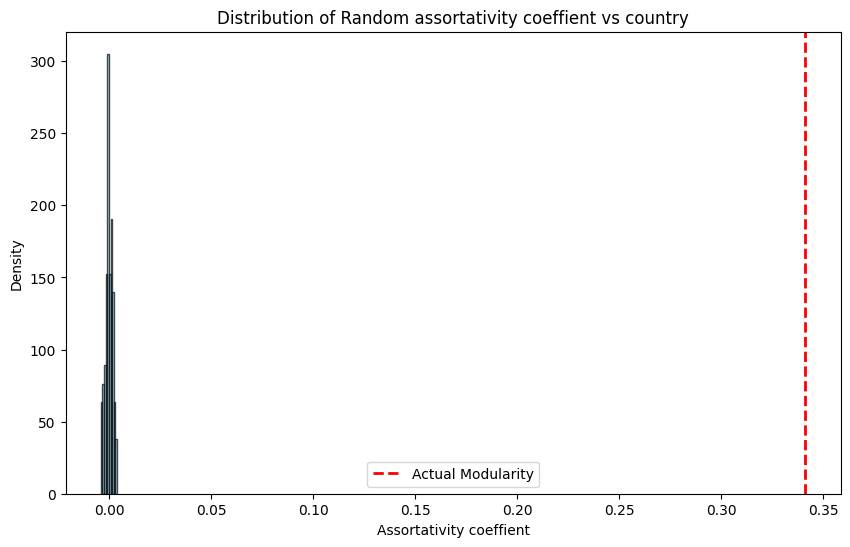

In [31]:
plt.figure(figsize=(10, 6))
plt.hist(coeffient_list, bins=10, density=True, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(r_real, color='red', linestyle='--', linewidth=2, label='Actual Modularity')
plt.xlabel('Assortativity coeffient')
plt.ylabel('Density')
plt.title('Distribution of Random assortativity coeffient vs country')
plt.legend()
plt.show()

The connections within the same country are significantly higher than random chance.

### Exercise 3: Zachary's karate club__: In this exercise, we will work on Zarachy's karate club graph (refer to the Introduction of Chapter 9). The dataset is available in NetworkX, by calling the function [karate_club_graph](https://networkx.org/documentation/stable//auto_examples/graph/plot_karate_club.html) 

1. Visualize the graph. Set the color of each node based on the club split (the information is stored as a node attribute). My version of the visualization is below.

In [32]:
Graph = nx.karate_club_graph()
list(Graph.nodes(data=True))[:3]

[(0, {'club': 'Mr. Hi'}), (1, {'club': 'Mr. Hi'}), (2, {'club': 'Mr. Hi'})]

In [33]:
for k,v in Graph.nodes(data=True):
    v["group"] = v["club"]
nw.visualize(Graph)

(None, None)

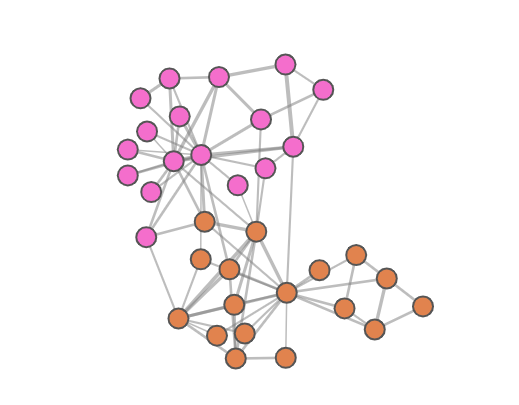

2. Write a function to compute the __modularity__ of a graph partitioning (use **equation 9.12** in the book). The function should take a networkX Graph and a partitioning as inputs and return the modularity.

In [34]:
def modularity(graph: nx.graph, partitioning: str):
    """
    Input:
    graph = nx.graph
    partitioning = string, desctiping the 
    """
    L = graph.number_of_edges()
    club = nx.get_node_attributes(Graph, partitioning)
    M = 0
    for value in set(club.values()):
        club_nodes = []
        for i in range(len(club)):
            if club[i] == value:
                club_nodes.append(i)
        sub_graph = graph.subgraph(club_nodes)
        Lc = sub_graph.number_of_edges()
        kc = sum(value for _, value in list(sub_graph.degree()))
        M += Lc/L-(kc/(2*L))**2
    return M

3. Explain in your own words the concept of _modularity_. 

Modularity is a quantity that can be used to compare communities. It is used on networks with groups or communities. It is between 0 and 1. High modularity means that there are many connections within the groups, but not many to the other groups

4. Compute the modularity of the Karate club split partitioning using the function you just wrote. Note: the Karate club split partitioning is avilable as a [node attribute](https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.classes.function.get_node_attributes.html), called _"club"_.

In [35]:
m_real = modularity(Graph,"club")
m_real

0.48931623931623935

5. Create $1000$ randomized version of the Karate Club network using the _double edge swap_ algorithm you wrote in the exercise above 5. For each of them, compute the modularity of the "club" split and store it in a list.

In [36]:
mod_list = []

for i in range(1000):
    G = double_edge_swap(Graph)
    m = modularity(G,"club")
    mod_list.append(m)
mod_list[0]

0.33284023668639057

6. Compute the average and standard deviation of the modularity for the random network.

In [37]:
np.mean(mod_list), np.std(mod_list)

(0.3648954635108481, 0.024683415068889065)

7. Plot the distribution of the "random" modularity. Plot the actual modularity of the club split as a vertical line (use [axvline](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axvline.html)). 

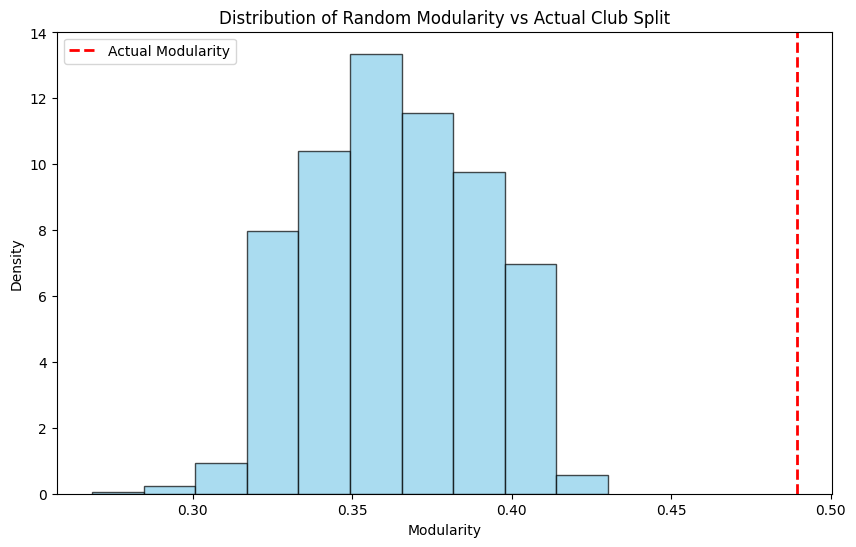

In [38]:
plt.figure(figsize=(10, 6))
plt.hist(mod_list, bins=10, density=True, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(m_real, color='red', linestyle='--', linewidth=2, label='Actual Modularity')
plt.xlabel('Modularity')
plt.ylabel('Density')
plt.title('Distribution of Random Modularity vs Actual Club Split')
plt.legend()
plt.show()

8. Comment on the figure. Is the club split a good partitioning? Why do you think I asked you to perform a randomization experiment? What is the reason why we preserved the nodes degree?

Club split seems to be a good partitoning, as the orginial is far higher than the randoms. I think we can use the randomization experiment, to say how often would this split randomly occur. That is also why we find the mean and standard deviation, too see how much of an outlier our result is <br>
We preserved the nodes degree, because we want to be able to compare the networks.

9.  Use [the Python Louvain-algorithm implementation](https://anaconda.org/auto/python-louvain) to find communities in this graph. Report the value of modularity found by the algorithm. Is it higher or lower than what you found above for the club split? What does this comparison reveal?

In [50]:
from community import community_louvain
partition = community_louvain.best_partition(Graph)
louvain_communities = {}
for node, comm_id in partition.items():
    if comm_id not in louvain_communities:
        louvain_communities[comm_id] = []
    louvain_communities[comm_id].append(node)
A = len(louvain_communities)
community_louvain.modularity(partition,Graph)

0.4345214669889994

The modulartity is lower than the one from orginal club split, but still higher than the random ones. This implies that the best split is the orginal

10.  Compare the communities found by the Louvain algorithm with the club split partitioning by creating a matrix **_D_** with dimension (2 times _A_), where _A_ is the number of communities found by Louvain. We set entry _D_(_i_,_j_) to be the number of nodes that community _i_ has in common with group split _j_. The matrix **_D_** is what we call a [**confusion matrix**](https://en.wikipedia.org/wiki/Confusion_matrix). Use the confusion matrix to explain how well the communities you've detected correspond to the club split partitioning.

In [51]:
D = np.zeros((A, 2), dtype=int)
club_split = [0 if Graph.nodes[i]['club'] == 'Mr. Hi' else 1 for i in Graph.nodes]

for louvain_id in louvain_communities:
    for node in louvain_communities[louvain_id]:
        club_id = club_split[node]
        D[louvain_id, club_id] += 1
D

array([[ 5,  0],
       [11,  0],
       [ 1, 17]])

The Louvain algorithm found 4 communities instead of the original 2. The confusion matrix can be explained as the first column is the club "Mr.Hi" while the secound is the "Officer". An ideal confusion matrix whould have been $[[17,0],[0,17]]$ <br>
It seems to split them well

## Part 3 - Words that characterize Computational Social Science communities

<Note that if the following code is re-run, the communities will change and all the following text answers will be different.>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ast
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.util import bigrams
import re
from collections import Counter
from scipy.stats import chi2
from nltk.tokenize import MWETokenizer
import json
from networkx.readwrite import json_graph
import community.community_louvain as community
import networkx as nx
from wordcloud import WordCloud
import textwrap


nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /Users/sadsa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/sadsa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Getting requirements needed for the exercises

#### Assignment of each author to their network community, and the degree of each author (relevent parts of week 6, ex 4)

In [130]:
# Compute the best partition (community assignment) using the louvain mathod 
partition = community.best_partition(Graph)

# get the degree of each author
degrees = dict(Graph.degree())

# number of communities
num_communities = len(set(partition.values()))
print(f"Number of communities found: {num_communities}")

# community sizes
community_sizes = Counter(partition.values())
print("Community sizes:", community_sizes)

# compute modularity
modularity = community.modularity(partition, Graph)
print(f"Modularity: {modularity:.4f}")

Number of communities found: 514
Community sizes: Counter({10: 1328, 8: 919, 15: 630, 13: 577, 4: 572, 11: 559, 3: 551, 34: 525, 28: 463, 17: 461, 31: 399, 9: 393, 40: 360, 0: 358, 30: 327, 26: 303, 24: 287, 32: 268, 60: 261, 6: 248, 12: 245, 47: 222, 87: 221, 55: 204, 42: 194, 29: 190, 35: 188, 44: 175, 45: 165, 52: 163, 78: 146, 63: 137, 37: 135, 81: 135, 23: 124, 27: 116, 20: 109, 16: 95, 104: 91, 49: 86, 122: 85, 53: 72, 7: 69, 18: 64, 59: 59, 74: 57, 124: 52, 93: 50, 77: 45, 159: 45, 98: 44, 167: 40, 89: 39, 22: 34, 88: 34, 70: 31, 85: 27, 117: 27, 118: 26, 147: 25, 80: 24, 126: 24, 69: 23, 58: 22, 160: 21, 73: 20, 75: 18, 156: 18, 171: 18, 46: 17, 84: 17, 99: 17, 72: 15, 144: 15, 153: 15, 125: 14, 57: 13, 79: 13, 92: 13, 111: 13, 112: 13, 135: 13, 158: 13, 33: 12, 95: 12, 143: 12, 149: 12, 155: 12, 51: 11, 108: 11, 177: 11, 66: 10, 133: 10, 54: 9, 76: 9, 90: 9, 97: 9, 136: 9, 145: 9, 151: 9, 161: 9, 162: 9, 170: 9, 103: 8, 107: 8, 138: 8, 140: 8, 173: 8, 176: 8, 64: 7, 116: 7, 14

In [131]:
# save author-community-degree (acd) data to a dataframe
df_acd = pd.DataFrame(list(partition.items()), columns=["author_id", "community"]) 
df_acd["degree"] = df_acd["author_id"].map(degrees)

In [132]:
df_acd

author_id  community  degree
0      https://openalex.org/A5067008528          0       6
1      https://openalex.org/A5022754313          0      25
2      https://openalex.org/A5044056170          0       4
3      https://openalex.org/A5012701585          0      17
4      https://openalex.org/A5071496598          0      15
...                                 ...        ...     ...
15096  https://openalex.org/A5007313170          1       0
15097  https://openalex.org/A5070124321          2       0
15098  https://openalex.org/A5025112887          5       0
15099  https://openalex.org/A5007178020         19       0
15100                               NaN         94       0

[15101 rows x 3 columns]

#### Get the tokenized abstracts dataframe (relevent parts of week 7, ex 2)

In [102]:
df_abstracts = pd.read_csv('final_abstracts.csv')

In [103]:
df_abstracts.head()

id  \
0  https://openalex.org/W3129422154   
1  https://openalex.org/W4392375089   
2  https://openalex.org/W3087570498   
3  https://openalex.org/W2905008240   
4  https://openalex.org/W3129992849   

                                               title  \
0  Expectations of reward and efficacy guide cogn...   
1  An experimental manipulation of the value of e...   
2  The impact of COVID-19 on the gender division ...   
3  The strength of long-range ties in population-...   
4  Promises and Perils of Experimentation: The Mu...   

                             abstract_inverted_index  
0  {'The': [0], 'amount': [1], 'of': [2, 26, 62, ...  
1                                                NaN  
2  {'As': [0], 'most': [1, 161], 'other': [2], 'E...  
3  {'The': [0], 'strength': [1], 'of': [2, 80], '...  
4  {'Researchers': [0], 'run': [1], 'experiments'...

Convert inverted index to text

In [104]:
# convert 'abstract_inverted_index' column from string to dictionary
df_abstracts['abstract_inverted_index'] = df_abstracts['abstract_inverted_index'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# remove rows where 'abstract_inverted_index' is nan or empty dictionary
df_abstracts = df_abstracts[df_abstracts['abstract_inverted_index'].apply(lambda x: isinstance(x, dict) and bool(x))]


In [105]:
# Define the function to convert the inverted index to plain text
def convert_inverted_to_text(inverted_index_str):
    
    # create list to hold the words in the correct order based on indices
    reconstructed_abstract = [''] * (max(max(indexes) for indexes in inverted_index_str.values()) + 1)
    
    # place each word at the corresponding index
    for word, indexes in inverted_index_str.items():
        for index in indexes:
            reconstructed_abstract[index] = word
            
    return ' '.join(reconstructed_abstract)

In [106]:
# Create new column 'text' in df_abstracts 
df_abstracts['text'] = df_abstracts['abstract_inverted_index'].apply(convert_inverted_to_text)

In [107]:
df_abstracts.head()

id  \
0  https://openalex.org/W3129422154   
2  https://openalex.org/W3087570498   
3  https://openalex.org/W2905008240   
4  https://openalex.org/W3129992849   
5  https://openalex.org/W4386387636   

                                               title  \
0  Expectations of reward and efficacy guide cogn...   
2  The impact of COVID-19 on the gender division ...   
3  The strength of long-range ties in population-...   
4  Promises and Perils of Experimentation: The Mu...   
5  High level of correspondence across different ...   

                             abstract_inverted_index  \
0  {'The': [0], 'amount': [1], 'of': [2, 26, 62, ...   
2  {'As': [0], 'most': [1, 161], 'other': [2], 'E...   
3  {'The': [0], 'strength': [1], 'of': [2, 80], '...   
4  {'Researchers': [0], 'run': [1], 'experiments'...   
5  {'Abstract': [0], 'One': [1], 'widely': [2], '...   

                                                text  
0  The amount of mental effort we invest in a tas...  
2  As most other EU countries, Hungary implemente...  
3  The strength of long-range ties It seems reaso...  
4  Researchers run experiments to test theories, ...  
5  Abstract One widely used approach for quantify...

Tokenization

In [108]:
# initialize the stemmer
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))  # load stopwords (to remove common words later)

In [110]:
# Define a function for tokenization, removal of stopwords (e.g., in, an, on, the, etc.), stemming (e.g., running -> run)

def tokenize_text(given_text):

    # convert to lowercase
    given_text = given_text.lower()
    
    # remove URLs, punctuation, numbers, and mathematical symbols
    given_text = re.sub(r"http\S+|www\S+", "", given_text)  # remove URLs
    given_text = re.sub(r"[^a-zA-Z\s]", "", given_text)  # keep only letters and spaces
    
    # tokenize
    tokens = word_tokenize(given_text)
    
    # remove stopwords and apply stemming
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    
    return tokens

In [111]:
# create new column 'tokens' in df_abstracts
df_abstracts['tokens'] = df_abstracts['text'].apply(tokenize_text)

In [112]:
df_abstracts.head()

id  \
0  https://openalex.org/W3129422154   
2  https://openalex.org/W3087570498   
3  https://openalex.org/W2905008240   
4  https://openalex.org/W3129992849   
5  https://openalex.org/W4386387636   

                                               title  \
0  Expectations of reward and efficacy guide cogn...   
2  The impact of COVID-19 on the gender division ...   
3  The strength of long-range ties in population-...   
4  Promises and Perils of Experimentation: The Mu...   
5  High level of correspondence across different ...   

                             abstract_inverted_index  \
0  {'The': [0], 'amount': [1], 'of': [2, 26, 62, ...   
2  {'As': [0], 'most': [1, 161], 'other': [2], 'E...   
3  {'The': [0], 'strength': [1], 'of': [2, 80], '...   
4  {'Researchers': [0], 'run': [1], 'experiments'...   
5  {'Abstract': [0], 'One': [1], 'widely': [2], '...   

                                                text  \
0  The amount of mental effort we invest in a tas...   
2  As most other EU countries, Hungary implemente...   
3  The strength of long-range ties It seems reaso...   
4  Researchers run experiments to test theories, ...   
5  Abstract One widely used approach for quantify...   

                                              tokens  
0  [amount, mental, effort, invest, task, influen...  
2  [eu, countri, hungari, implement, sever, lockd...  
3  [strength, longrang, tie, seem, reason, would,...  
4  [research, run, experi, test, theori, search, ...  
5  [abstract, one, wide, use, approach, quantifi,...

In [113]:
# Add column of bigrams for each abstract 
df_abstracts['bigrams'] = df_abstracts['tokens'].apply(lambda tokens: list(bigrams(tokens)))

In [119]:
df_abstracts.head()

id  \
0  https://openalex.org/W3129422154   
2  https://openalex.org/W3087570498   
3  https://openalex.org/W2905008240   
4  https://openalex.org/W3129992849   
5  https://openalex.org/W4386387636   

                                               title  \
0  Expectations of reward and efficacy guide cogn...   
2  The impact of COVID-19 on the gender division ...   
3  The strength of long-range ties in population-...   
4  Promises and Perils of Experimentation: The Mu...   
5  High level of correspondence across different ...   

                             abstract_inverted_index  \
0  {'The': [0], 'amount': [1], 'of': [2, 26, 62, ...   
2  {'As': [0], 'most': [1, 161], 'other': [2], 'E...   
3  {'The': [0], 'strength': [1], 'of': [2, 80], '...   
4  {'Researchers': [0], 'run': [1], 'experiments'...   
5  {'Abstract': [0], 'One': [1], 'widely': [2], '...   

                                                text  \
0  The amount of mental effort we invest in a tas...   
2  As most other EU countries, Hungary implemente...   
3  The strength of long-range ties It seems reaso...   
4  Researchers run experiments to test theories, ...   
5  Abstract One widely used approach for quantify...   

                                              tokens  \
0  [amount, mental, effort, invest, task, influen...   
2  [eu, countri, hungari, implement, sever, lockd...   
3  [strength, longrang, tie, seem, reason, would,...   
4  [research, run, experi, test, theori, search, ...   
5  [abstract, one, wide, use, approach, quantifi,...   

                                             bigrams  
0  [(amount, mental), (mental, effort), (effort, ...  
2  [(eu, countri), (countri, hungari), (hungari, ...  
3  [(strength, longrang), (longrang, tie), (tie, ...  
4  [(research, run), (run, experi), (experi, test...  
5  [(abstract, one), (one, wide), (wide, use), (u...

In [115]:
# Combine bigrams into a single string for each abstract (note about 2-4 minutes to run)
all_bigrams = sum(df_abstracts["bigrams"].tolist(), [])

Compute contingency tables

In [120]:
# count occurences of all bigrams 
bigram_counts = Counter(all_bigrams)

In [121]:
# get unique words 
all_words = sum(df_abstracts["tokens"].tolist(), [])  # flatten token list
word_counts = Counter(all_words)
total_words = len(all_words)

In [122]:
all_words[:10], all_bigrams[:10]

(['amount',
  'mental',
  'effort',
  'invest',
  'task',
  'influenc',
  'reward',
  'expect',
  'perform',
  'task'],
 [('amount', 'mental'),
  ('mental', 'effort'),
  ('effort', 'invest'),
  ('invest', 'task'),
  ('task', 'influenc'),
  ('influenc', 'reward'),
  ('reward', 'expect'),
  ('expect', 'perform'),
  ('perform', 'task'),
  ('task', 'well')])

In [123]:
bigram_stats = []
for (word1, word2), bigram_count in bigram_counts.items():
    
    # get observed counts (variable names are from theory in lecture notes)
    nii = bigram_count 
    nio = word_counts[word1] - bigram_count # bigrams where first word is word1 and second word is not word2
    noi = word_counts[word2] - bigram_count # bigrams where first word is not word1 and second word is word2
    noo = total_words - (nii + nio + noi) # bigrams where first word is not word1 and second word is not word2

    # get expected counts
    R1 = nii + nio # the bigrams containing word1 (sum of first row)
    C1 = nii + noi # the bigrams containing word2 (sum of first column)
    R2 = noi + noo # the bigrams not containing word1 (sum of second row)
    C2 = nio + noo # the bigrams not containing word2 (sum of second column)

    N = nii + nio + noi + noo # total number of bigrams

    E11 = (R1 * C1) / N
    E12 = (R1 * C2) / N
    E13 = (R2 * C1) / N
    E14 = (R2 * C2) / N

    # compute chi-squared statistic
    chi_square = sum(
        (O - E) ** 2 / E
        for O, E in zip([nii, nio, noi, noo], [E11, E12, E13, E14])
        if E > 0
    )

    # compute p-value
    p_value = chi2.sf(chi_square, df=1)

    bigram_stats.append((word1, word2, nii, chi_square, p_value))


In [124]:
# convert to dataframe
bigram_df = pd.DataFrame(bigram_stats, columns=["word1", "word2", "count", "chi2", "p_value"])

In [125]:
bigram_df.head()

word1     word2  count        chi2        p_value
0  amount    mental      2    3.159056   7.550685e-02
1  mental    effort     21  519.078782  6.713755e-115
2  effort    invest     11  315.358333   1.485865e-70
3  invest      task      6    6.391010   1.146997e-02
4    task  influenc      5    5.888028   1.524416e-02

In [126]:
# Identify collocations i.e., find bigrams that appear more than 50 times and have p-value < 0.001
collocations = bigram_df[(bigram_df["count"] > 50) & (bigram_df["p_value"] < 0.001)]
collocations_sorted = collocations.sort_values(by="count", ascending=False)

print(collocations_sorted.head(20))

            word1    word2  count          chi2  p_value
877        social    media   3570  3.676996e+05      0.0
183        social  network   2802  8.516929e+04      0.0
2659       result     show   1558  4.007759e+04      0.0
4012       machin    learn   1355  1.943633e+05      0.0
1376       neural  network   1094  9.936744e+04      0.0
2577        paper  present    986  4.083884e+04      0.0
382        result  suggest    949  2.981371e+04      0.0
191            et       al    907  2.144077e+06      0.0
977          data  collect    885  2.855053e+04      0.0
2972         data      set    857  1.612777e+04      0.0
13674       paper   propos    821  2.451014e+04      0.0
1063        decis     make    793  8.279499e+04      0.0
1378        natur  languag    774  1.024890e+05      0.0
2817        googl  scholar    767  1.179650e+06      0.0
22356  experiment   result    743  4.626869e+04      0.0
32389    reinforc    learn    724  1.055572e+05      0.0
2785         unit    state    6

In [127]:
# Recompute tokens using MWETokenizer

# create list of collocations as tuples
collocation_tuples = [tuple(x) for x in collocations_sorted[["word1", "word2"]].values]

# initialize MWETokenizer
tokenizer = MWETokenizer(collocation_tuples)

# apply tokenizer to the 'tokens' column
df_abstracts['tokens'] = df_abstracts['tokens'].apply(lambda x: tokenizer.tokenize(x))

In [128]:
df_abstracts.head()

id  \
0  https://openalex.org/W3129422154   
2  https://openalex.org/W3087570498   
3  https://openalex.org/W2905008240   
4  https://openalex.org/W3129992849   
5  https://openalex.org/W4386387636   

                                               title  \
0  Expectations of reward and efficacy guide cogn...   
2  The impact of COVID-19 on the gender division ...   
3  The strength of long-range ties in population-...   
4  Promises and Perils of Experimentation: The Mu...   
5  High level of correspondence across different ...   

                             abstract_inverted_index  \
0  {'The': [0], 'amount': [1], 'of': [2, 26, 62, ...   
2  {'As': [0], 'most': [1, 161], 'other': [2], 'E...   
3  {'The': [0], 'strength': [1], 'of': [2, 80], '...   
4  {'Researchers': [0], 'run': [1], 'experiments'...   
5  {'Abstract': [0], 'One': [1], 'widely': [2], '...   

                                                text  \
0  The amount of mental effort we invest in a tas...   
2  As most other EU countries, Hungary implemente...   
3  The strength of long-range ties It seems reaso...   
4  Researchers run experiments to test theories, ...   
5  Abstract One widely used approach for quantify...   

                                              tokens  \
0  [amount, mental, effort, invest, task, influen...   
2  [eu, countri, hungari, implement, sever, lockd...   
3  [strength, longrang, tie, seem, reason, would,...   
4  [research, run, experi_test, theori, search, d...   
5  [abstract, one, wide_use, approach, quantifi, ...   

                                             bigrams  
0  [(amount, mental), (mental, effort), (effort, ...  
2  [(eu, countri), (countri, hungari), (hungari, ...  
3  [(strength, longrang), (longrang, tie), (tie, ...  
4  [(research, run), (run, experi), (experi, test...  
5  [(abstract, one), (one, wide), (wide, use), (u...

We now have the final tokenized abstracts data set called `df_abstracts`

### Exercise 1: TF-IDF and the Computational Social Science communities

Explain in your own words the point of TF-IDF. What does TF stand for? What does IDF stand for?

TF-IDF stands for Term Frequency-Inverse Document Frequency and it measures how important a particular word, is relative to a collection of documents, referred to as the corpus. We use TF-IDF in NLP and text analysis because it identifies important words by downweighting frequent words (such as "the", "is", and "and") and highlights rare but important words in a specific document. This can improve search and information retrieval when search engines use TF-IDF to rank documents by relevance, for example, if a query word has high TF-IDF in a document, then that document would be considered more relevant. TF-IDF can also help with spam detection, sentiment analysis, and keyword extraction. Instead of just counting words like the bag-of-words model which treats all words as equally important, TF-IDF gives weight to words that are important or informative relative to the rest of the documents.

In [208]:
# read in the original dataframes
df_papers_orig = pd.read_csv('final_papers.csv')
df_authors_orig = pd.read_csv('final_authors.csv')

Find out which words are important for each community

In [209]:
# merge df_abstracts with df_papers_orig on 'id' which is the paper id
df_merged1 = df_abstracts.merge(df_papers_orig, on="id", how="left")

In [210]:
df_merged1.head()

id  \
0  https://openalex.org/W3129422154   
1  https://openalex.org/W3087570498   
2  https://openalex.org/W2905008240   
3  https://openalex.org/W3129992849   
4  https://openalex.org/W4386387636   

                                               title  \
0  Expectations of reward and efficacy guide cogn...   
1  The impact of COVID-19 on the gender division ...   
2  The strength of long-range ties in population-...   
3  Promises and Perils of Experimentation: The Mu...   
4  High level of correspondence across different ...   

                             abstract_inverted_index  \
0  {'The': [0], 'amount': [1], 'of': [2, 26, 62, ...   
1  {'As': [0], 'most': [1, 161], 'other': [2], 'E...   
2  {'The': [0], 'strength': [1], 'of': [2, 80], '...   
3  {'Researchers': [0], 'run': [1], 'experiments'...   
4  {'Abstract': [0], 'One': [1], 'widely': [2], '...   

                                                text  \
0  The amount of mental effort we invest in a tas...   
1  As most other EU countries, Hungary implemente...   
2  The strength of long-range ties It seems reaso...   
3  Researchers run experiments to test theories, ...   
4  Abstract One widely used approach for quantify...   

                                              tokens  \
0  [amount, mental, effort, invest, task, influen...   
1  [eu, countri, hungari, implement, sever, lockd...   
2  [strength, longrang, tie, seem, reason, would,...   
3  [research, run, experi_test, theori, search, d...   
4  [abstract, one, wide_use, approach, quantifi, ...   

                                             bigrams  publication_year  \
0  [(amount, mental), (mental, effort), (effort, ...              2021   
1  [(eu, countri), (countri, hungari), (hungari, ...              2020   
2  [(strength, longrang), (longrang, tie), (tie, ...              2018   
3  [(research, run), (run, experi), (experi, test...              2021   
4  [(abstract, one), (one, wide), (wide, use), (u...              2023   

   cited_by_count                                         author_ids  
0             189  ['https://openalex.org/A5067008528', 'https://...  
1             124  ['https://openalex.org/A5069473136', 'https://...  
2              90  ['https://openalex.org/A5034327826', 'https://...  
3              56  ['https://openalex.org/A5022754313', 'https://...  
4              26  ['https://openalex.org/A5022754313', 'https://...

We now need to separate out each author on its own row in the df_merged1 dataframe. Then we will merge the resulting dataframe with df_acd and then with df_authors_orig on author_id.

In [211]:
df_merged1['author_ids'] = df_merged1['author_ids'].apply(ast.literal_eval) # convert each string to a list

In [212]:
df_merged1_exploded = df_merged1.explode('author_ids') # get each author on a separate row

In [213]:
df_merged1_exploded.head()

id  \
0  https://openalex.org/W3129422154   
0  https://openalex.org/W3129422154   
0  https://openalex.org/W3129422154   
0  https://openalex.org/W3129422154   
0  https://openalex.org/W3129422154   

                                               title  \
0  Expectations of reward and efficacy guide cogn...   
0  Expectations of reward and efficacy guide cogn...   
0  Expectations of reward and efficacy guide cogn...   
0  Expectations of reward and efficacy guide cogn...   
0  Expectations of reward and efficacy guide cogn...   

                             abstract_inverted_index  \
0  {'The': [0], 'amount': [1], 'of': [2, 26, 62, ...   
0  {'The': [0], 'amount': [1], 'of': [2, 26, 62, ...   
0  {'The': [0], 'amount': [1], 'of': [2, 26, 62, ...   
0  {'The': [0], 'amount': [1], 'of': [2, 26, 62, ...   
0  {'The': [0], 'amount': [1], 'of': [2, 26, 62, ...   

                                                text  \
0  The amount of mental effort we invest in a tas...   
0  The amount of mental effort we invest in a tas...   
0  The amount of mental effort we invest in a tas...   
0  The amount of mental effort we invest in a tas...   
0  The amount of mental effort we invest in a tas...   

                                              tokens  \
0  [amount, mental, effort, invest, task, influen...   
0  [amount, mental, effort, invest, task, influen...   
0  [amount, mental, effort, invest, task, influen...   
0  [amount, mental, effort, invest, task, influen...   
0  [amount, mental, effort, invest, task, influen...   

                                             bigrams  publication_year  \
0  [(amount, mental), (mental, effort), (effort, ...              2021   
0  [(amount, mental), (mental, effort), (effort, ...              2021   
0  [(amount, mental), (mental, effort), (effort, ...              2021   
0  [(amount, mental), (mental, effort), (effort, ...              2021   
0  [(amount, mental), (mental, effort), (effort, ...              2021   

   cited_by_count                        author_ids  
0             189  https://openalex.org/A5067008528  
0             189  https://openalex.org/A5022754313  
0             189  https://openalex.org/A5044056170  
0             189  https://openalex.org/A5012701585  
0             189  https://openalex.org/A5071496598

In [214]:
# merge df_merged1_exploded with df_acd on 'author_ids' and 'author_id'
df_merged2 = df_merged1_exploded.merge(df_acd, left_on="author_ids", right_on="author_id", how="left")
df_merged2 = df_merged2.drop(columns=["author_ids"]) # remove the author_ids column as we already have author_id

In [215]:
df_merged2.head(20)

id  \
0   https://openalex.org/W3129422154   
1   https://openalex.org/W3129422154   
2   https://openalex.org/W3129422154   
3   https://openalex.org/W3129422154   
4   https://openalex.org/W3129422154   
5   https://openalex.org/W3087570498   
6   https://openalex.org/W3087570498   
7   https://openalex.org/W3087570498   
8   https://openalex.org/W3087570498   
9   https://openalex.org/W2905008240   
10  https://openalex.org/W2905008240   
11  https://openalex.org/W2905008240   
12  https://openalex.org/W3129992849   
13  https://openalex.org/W3129992849   
14  https://openalex.org/W3129992849   
15  https://openalex.org/W4386387636   
16  https://openalex.org/W4386387636   
17  https://openalex.org/W4386387636   
18  https://openalex.org/W4386387636   
19  https://openalex.org/W4386387636   

                                                title  \
0   Expectations of reward and efficacy guide cogn...   
1   Expectations of reward and efficacy guide cogn...   
2   Expectations of reward and efficacy guide cogn...   
3   Expectations of reward and efficacy guide cogn...   
4   Expectations of reward and efficacy guide cogn...   
5   The impact of COVID-19 on the gender division ...   
6   The impact of COVID-19 on the gender division ...   
7   The impact of COVID-19 on the gender division ...   
8   The impact of COVID-19 on the gender division ...   
9   The strength of long-range ties in population-...   
10  The strength of long-range ties in population-...   
11  The strength of long-range ties in population-...   
12  Promises and Perils of Experimentation: The Mu...   
13  Promises and Perils of Experimentation: The Mu...   
14  Promises and Perils of Experimentation: The Mu...   
15  High level of correspondence across different ...   
16  High level of correspondence across different ...   
17  High level of correspondence across different ...   
18  High level of correspondence across different ...   
19  High level of correspondence across different ...   

                              abstract_inverted_index  \
0   {'The': [0], 'amount': [1], 'of': [2, 26, 62, ...   
1   {'The': [0], 'amount': [1], 'of': [2, 26, 62, ...   
2   {'The': [0], 'amount': [1], 'of': [2, 26, 62, ...   
3   {'The': [0], 'amount': [1], 'of': [2, 26, 62, ...   
4   {'The': [0], 'amount': [1], 'of': [2, 26, 62, ...   
5   {'As': [0], 'most': [1, 161], 'other': [2], 'E...   
6   {'As': [0], 'most': [1, 161], 'other': [2], 'E...   
7   {'As': [0], 'most': [1, 161], 'other': [2], 'E...   
8   {'As': [0], 'most': [1, 161], 'other': [2], 'E...   
9   {'The': [0], 'strength': [1], 'of': [2, 80], '...   
10  {'The': [0], 'strength': [1], 'of': [2, 80], '...   
11  {'The': [0], 'strength': [1], 'of': [2, 80], '...   
12  {'Researchers': [0], 'run': [1], 'experiments'...   
13  {'Researchers': [0], 'run': [1], 'experiments'...   
14  {'Researchers': [0], 'run': [1], 'experiments'...   
15  {'Abstract': [0], 'One': [1], 'widely': [2], '...   
16  {'Abstract': [0], 'One': [1], 'widely': [2], '...   
17  {'Abstract': [0], 'One': [1], 'widely': [2], '...   
18  {'Abstract': [0], 'One': [1], 'widely': [2], '...   
19  {'Abstract': [0], 'One': [1], 'widely': [2], '...   

                                                 text  \
0   The amount of mental effort we invest in a tas...   
1   The amount of mental effort we invest in a tas...   
2   The amount of mental effort we invest in a tas...   
3   The amount of mental effort we invest in a tas...   
4   The amount of mental effort we invest in a tas...   
5   As most other EU countries, Hungary implemente...   
6   As most other EU countries, Hungary implemente...   
7   As most other EU countries, Hungary implemente...   
8   As most other EU countries, Hungary implemente...   
9   The strength of long-range ties It seems reaso...   
10  The strength of long-range ties It seems reaso...   
11  The strength of long-range ties It seems reaso...   
12  Researchers run experiments to test theories, ...   

In [216]:
# merge df_merged2 with df_authors_orig
df_final = pd.merge(df_merged2, df_authors_orig, left_on="author_id", right_on="id", how="left")
df_final = df_final.drop(columns=["id_y"]) # remove id_y as we already have author_id column. note that id_x is the paper id now

In [217]:
df_final.head(20)

id_x  \
0   https://openalex.org/W3129422154   
1   https://openalex.org/W3129422154   
2   https://openalex.org/W3129422154   
3   https://openalex.org/W3129422154   
4   https://openalex.org/W3129422154   
5   https://openalex.org/W3087570498   
6   https://openalex.org/W3087570498   
7   https://openalex.org/W3087570498   
8   https://openalex.org/W3087570498   
9   https://openalex.org/W2905008240   
10  https://openalex.org/W2905008240   
11  https://openalex.org/W2905008240   
12  https://openalex.org/W3129992849   
13  https://openalex.org/W3129992849   
14  https://openalex.org/W3129992849   
15  https://openalex.org/W4386387636   
16  https://openalex.org/W4386387636   
17  https://openalex.org/W4386387636   
18  https://openalex.org/W4386387636   
19  https://openalex.org/W4386387636   

                                                title  \
0   Expectations of reward and efficacy guide cogn...   
1   Expectations of reward and efficacy guide cogn...   
2   Expectations of reward and efficacy guide cogn...   
3   Expectations of reward and efficacy guide cogn...   
4   Expectations of reward and efficacy guide cogn...   
5   The impact of COVID-19 on the gender division ...   
6   The impact of COVID-19 on the gender division ...   
7   The impact of COVID-19 on the gender division ...   
8   The impact of COVID-19 on the gender division ...   
9   The strength of long-range ties in population-...   
10  The strength of long-range ties in population-...   
11  The strength of long-range ties in population-...   
12  Promises and Perils of Experimentation: The Mu...   
13  Promises and Perils of Experimentation: The Mu...   
14  Promises and Perils of Experimentation: The Mu...   
15  High level of correspondence across different ...   
16  High level of correspondence across different ...   
17  High level of correspondence across different ...   
18  High level of correspondence across different ...   
19  High level of correspondence across different ...   

                              abstract_inverted_index  \
0   {'The': [0], 'amount': [1], 'of': [2, 26, 62, ...   
1   {'The': [0], 'amount': [1], 'of': [2, 26, 62, ...   
2   {'The': [0], 'amount': [1], 'of': [2, 26, 62, ...   
3   {'The': [0], 'amount': [1], 'of': [2, 26, 62, ...   
4   {'The': [0], 'amount': [1], 'of': [2, 26, 62, ...   
5   {'As': [0], 'most': [1, 161], 'other': [2], 'E...   
6   {'As': [0], 'most': [1, 161], 'other': [2], 'E...   
7   {'As': [0], 'most': [1, 161], 'other': [2], 'E...   
8   {'As': [0], 'most': [1, 161], 'other': [2], 'E...   
9   {'The': [0], 'strength': [1], 'of': [2, 80], '...   
10  {'The': [0], 'strength': [1], 'of': [2, 80], '...   
11  {'The': [0], 'strength': [1], 'of': [2, 80], '...   
12  {'Researchers': [0], 'run': [1], 'experiments'...   
13  {'Researchers': [0], 'run': [1], 'experiments'...   
14  {'Researchers': [0], 'run': [1], 'experiments'...   
15  {'Abstract': [0], 'One': [1], 'widely': [2], '...   
16  {'Abstract': [0], 'One': [1], 'widely': [2], '...   
17  {'Abstract': [0], 'One': [1], 'widely': [2], '...   
18  {'Abstract': [0], 'One': [1], 'widely': [2], '...   
19  {'Abstract': [0], 'One': [1], 'widely': [2], '...   

                                                 text  \
0   The amount of mental effort we invest in a tas...   
1   The amount of mental effort we invest in a tas...   
2   The amount of mental effort we invest in a tas...   
3   The amount of mental effort we invest in a tas...   
4   The amount of mental effort we invest in a tas...   
5   As most other EU countries, Hungary implemente...   
6   As most other EU countries, Hungary implemente...   
7   As most other EU countries, Hungary implemente...   
8   As most other EU countries, Hungary implemente...   
9   The strength of long-range ties It seems reaso...   
10  The strength of long-range ties It seems reaso...   
11  The strength of long-range ties It seems reaso...   
12  Researchers run experiments to test theories, ... 

We now have the final dataframe called `df_final` with all the information we need to proceed with exercise 1.

Now, we want to find out which words are important for each community, so we're going to create several *large documents, one for each community*

In [218]:
# make a dictionary where each key is the community and value is the list of all the tokens in that community
comm_docs = df_final.groupby("community")["tokens"].apply(lambda x: sum(x, [])).to_dict() 

# store back into a dataframe
df_comm_docs = pd.DataFrame(comm_docs.items(), columns=["community", "tokens"])

In [219]:
# just checking
df_comm_docs.isna().sum()

community    0
tokens       0
dtype: int64

In [220]:
df_comm_docs.head()

community                                             tokens
0          0  [amount, mental, effort, invest, task, influen...
1          3  [strength, longrang, tie, seem, reason, would,...
2          4  [abstract, one, wide_use, approach, quantifi, ...
3          6  [abstract, gener, artifici_intellig, ai, model...
4          7  [book, consist, chapter, divid, seven, part, s...

Use the method of your choice to find the top 5 terms within the top 5 communities (by number of authors).

The weight scheme used will be raw count.

In [221]:
# count number of authors per community 
author_counts = df_final.groupby('community')['author_id'].nunique().sort_values(ascending=False)

# get top 5 communities by author_counts
top_5_communities = author_counts.head(5).index.tolist()
top_5_communities

[10, 8, 15, 13, 4]

In [222]:
# filter df_comm_docs to get the tokens for the top 5 communities
top_5_community_tokens = df_comm_docs[df_comm_docs['community'].isin(top_5_communities)]
top_5_community_tokens.head()

community                                             tokens
2           4  [abstract, one, wide_use, approach, quantifi, ...
5           8  [text_gener, larg_languag, model, prolifer, be...
7          10  [conflict, fuel, popular, religi, mobil, rekin...
10         13  [world, digit, inform, ecosystem, continu, str...
12         15  [abstract, one, wide_use, approach, quantifi, ...

In [ ]:
# find the top 5 terms in each of the top 5 communities

top_5_exploded = top_5_community_tokens.explode('tokens') # get each token on a separate row

# count occurences of each token in each community
term_counts = top_5_exploded.groupby(["community"])["tokens"].value_counts()

# get top 5 terms for each community
top_5_terms_per_community = (
    term_counts.groupby(level=0)  # group by community (note that term_counts is a pandas Series)
    .nlargest(5)  # get 5 most frequent terms 
    .reset_index(level=0, drop=True)  # reset index for cleaner output
)

# convert to dictionary-like format for easy access while printing
top_5_terms_dict = (
    top_5_terms_per_community.groupby(level=0)
    .apply(lambda x: list(x.index.get_level_values(1)))  # extract just the tokens (words) from the index
    .to_dict()
)

# print results
for community, terms in top_5_terms_dict.items():
    print(f"Community {community}: {terms}")

Community 4: ['use', 'peopl', 'effect', 'inform', 'model']
Community 8: ['model', 'use', 'task', 'gener', 'system']
Community 10: ['use', 'user', 'design', 'commun', 'particip']
Community 13: ['user', 'network', 'use', 'model', 'studi']
Community 15: ['polit', 'effect', 'use', 'find', 'studi']


Describe similarities and differences between the communities.

[Note that the similarities and differences discussed below will be based on the 5 top frequent token list for the top 5 communities.]

Similarities: The word "use" appears in all five communities, indicating a broad interest in practical applications or methodologies. The word "model" appears in Communities 4, 8, and 13, suggesting that these communities could have a strong focus on modeling approaches. The presence of words like "polit" (politics) in Community 15, "commun" (communication) in Community 10, and "network" in Community 13 suggests that some communities have a social science or interdisciplinary focus, integrating computational methods with societal studies.

Differences: Community 8 contains "model", "task", "system", which aligns more with AI, machine learning, or computational task-solving while community 10 includes "design" "commun" (communication) and "particip" (participation), indicating a focus on user-centered research, participatory design, or communication systems.

Why aren't the TFs not necessarily a good description of the communities?

TFs alone may not be the best descriptrs because high-frequency words like "use" and "model" appear in multiple communities, making them less effective at differentiating between different research focuses. These frequent words may be general terms used across various fields rather than terms specific to a particular community. TF counts also do not capture the meaning or context of words. For example, "model" could refer to statistical models, AI models, or conceptual models, depending on the research area. Hence, communities with different focuses may share common words but discuss entirely different topics.

Next, we calculate IDF for every token in each of the top 5 communities. We will do this by implementing the following formula on the words (adapted from: https://en.wikipedia.org/wiki/Tf%E2%80%93idf):

$$
\text{IDF}(w) = \log \frac{N}{1 + df(w)}
$$

where:  
   - $N$ = total number of communities  
   - $df(w)$ = number of communities in which the word appears  
   - Adding 1 in the denominator prevents division by zero.

In [ ]:
# get unique words in each of the top 5 communities
word_in_communities = top_5_exploded.groupby("tokens")["community"].nunique()

# total number of communities 
tot_num = df_comm_docs["community"].nunique()

# compute idf
idf_scores = np.log(tot_num / (1 + word_in_communities))

# convert to a DataFrame for readability
idf_df = idf_scores.reset_index()
idf_df.columns = ["word", "IDF"]

In [226]:
idf_df

word       IDF
0          aa  3.676301
1         aaa  4.369448
2        aaai  3.676301
3         aab  4.369448
4         aac  4.369448
...       ...       ...
34720    zuco  3.963983
34721    zuom  4.369448
34722  zurich  3.676301
34723  zuylen  3.963983
34724    zync  4.369448

[34725 rows x 2 columns]

What base logarithm did you use? Is that important?

By default, base e was used. While the choice of base affects the actual numerical values of IDF scores, it doesn't affect the ranking of words (since logarithms of different bases are proportional to each other). Hence, it effectively does not make a difference. 

We're ready to calculate TF-IDF. Do that for the top 9 communities (by number of authors).

In [227]:
# get top 9 communities by author_counts
top_9_communities = author_counts.head(9).index.tolist()
top_9_communities

[10, 8, 15, 13, 4, 11, 3, 34, 28]

In [229]:
# filter df_comm_docs to get the tokens for the top 9 communities
top_9_community_tokens = df_comm_docs[df_comm_docs['community'].isin(top_9_communities)]
top_9_community_tokens.head(9)

community                                             tokens
1           3  [strength, longrang, tie, seem, reason, would,...
2           4  [abstract, one, wide_use, approach, quantifi, ...
5           8  [text_gener, larg_languag, model, prolifer, be...
7          10  [conflict, fuel, popular, religi, mobil, rekin...
8          11  [abstract, unpreced, behaviour, respons, socie...
10         13  [world, digit, inform, ecosystem, continu, str...
12         15  [abstract, one, wide_use, approach, quantifi, ...
24         28  [complex, mani, biolog, social, technolog, sys...
30         34  [applaud, matz, et_al, use, field_studi, faceb...

In [ ]:
# compute tf (weighting is based on raw count)
top_9_exploded = top_9_community_tokens.explode('tokens') # get each token on a separate row
tf = top_9_exploded.groupby(["community"])["tokens"].value_counts()

In [279]:
# compute document frequency for each word (i.e., number of communities in which the word appears)
df = df_final.explode('tokens').groupby("tokens")["community"].nunique()

# compute df using log base e
N = df_comm_docs["community"].nunique()
idf = np.log(N / (1 + df))

IDF can be calculated by multiplying tf and df.

In [280]:
tf_idf = tf * idf

# convert to DataFrame for readability
tf_idf_dataframe = tf_idf.reset_index()
tf_idf_dataframe.columns = ["community", "tokens", "tf-idf"]

In [281]:
tf_idf_dataframe

community     tokens       tf-idf
0               3      model   700.814330
1               3   individu   830.481412
2               3      popul   976.240623
3               3     cooper  1520.218772
4               3        use   315.016632
...           ...        ...          ...
116437         34        zhu     2.760010
116438         34       zhuo     3.963983
116439         34  zinkevich     3.453157
116440         34       zone     1.596859
116441         34     zotero     2.760010

[116442 rows x 3 columns]

For each community in the top 9, list the top 10 TF words

In [282]:
# get top 10 tf words for each community
top_10_tf_words = (
    tf.groupby(level=0)  # group by community 
    .nlargest(10)  # get 10 most frequent terms 
    .reset_index(level=0, drop=True)  # reset index for cleaner output
)

# convert to dictionary-like format for easy access while printing
top_10_tf_words_dict = (
    top_10_tf_words.groupby(level=0)
    .apply(lambda x: list(x.index.get_level_values(1)))  # extract just the tokens (words) from the index
    .to_dict()
)

# print top 10 words for each community
for community, words in top_10_tf_words_dict.items():
    print(f"Community {community} - Top 10 TF words: {words}")

Community 3 - Top 10 TF words: ['model', 'individu', 'popul', 'cooper', 'use', 'system', 'dynam', 'result', 'time', 'gener']
Community 4 - Top 10 TF words: ['use', 'peopl', 'effect', 'inform', 'model', 'differ', 'particip', 'decis', 'individu', 'research']
Community 8 - Top 10 TF words: ['model', 'use', 'task', 'gener', 'system', 'data', 'learn', 'dataset', 'method', 'perform']
Community 10 - Top 10 TF words: ['use', 'user', 'design', 'commun', 'particip', 'system', 'data', 'task', 'peopl', 'research']
Community 11 - Top 10 TF words: ['network', 'model', 'find', 'use', 'dynam', 'system', 'studi', 'individu', 'differ', 'distribut']
Community 13 - Top 10 TF words: ['user', 'network', 'use', 'model', 'studi', 'data', 'inform', 'differ', 'commun', 'system']
Community 15 - Top 10 TF words: ['polit', 'effect', 'use', 'find', 'studi', 'inform', 'data', 'research', 'measur', 'polici']
Community 28 - Top 10 TF words: ['model', 'agent', 'use', 'individu', 'cultur', 'gener', 'show', 'human', 'alg

For each community in the top 9, list the top 10 TF-IDF words

In [283]:
# get top 10 tf-idf words for each community
top_10_tfidf_words = (
    tf_idf.groupby(level=0)  # group by community 
    .nlargest(10)   
    .reset_index(level=0, drop=True)  # reset index for cleaner output
)

# convert to dictionary-like format for easy access while printing
top_10_tfidf_words_dict = (
    top_10_tfidf_words.groupby(level=0)
    .apply(lambda x: list(x.index.get_level_values(1)))  # extract just the tokens (words) from the index
    .to_dict()
)

# print
for community, words in top_10_tfidf_words_dict.items():
    print(f"Community {community} - Top 10 TF-IDF words: {words}")

Community 3 - Top 10 TF-IDF words: ['cooper', 'popul', 'influenza', 'individu', 'dynam', 'transmiss', 'speci', 'epidem', 'model', 'leprosi']
Community 4 - Top 10 TF-IDF words: ['peopl', 'misinform', 'judgment', 'decis', 'heurist', 'particip', 'survey', 'respond', 'cognit', 'choic']
Community 8 - Top 10 TF-IDF words: ['task', 'model', 'dataset', 'text', 'word', 'languag', 'natur_languag', 'annot', 'learn', 'user']
Community 10 - Top 10 TF-IDF words: ['user', 'commun', 'design', 'peopl', 'particip', 'task', 'social_media', 'onlin', 'interact', 'visual']
Community 11 - Top 10 TF-IDF words: ['network', 'dynam', 'find', 'node', 'expon', 'distribut', 'individu', 'citi', 'model', 'scale']
Community 13 - Top 10 TF-IDF words: ['user', 'network', 'twitter', 'social_media', 'epidem', 'bot', 'spread', 'social', 'commun', 'popular']
Community 15 - Top 10 TF-IDF words: ['polit', 'elect', 'belief', 'voter', 'vote', 'partisan', 'social_media', 'parti', 'polici', 'news']
Community 28 - Top 10 TF-IDF wo

Are these 10 words more descriptive of the community? If yes, what is it about IDF that makes the words more informative?



Yes, the 10 words in the TF-IDF list are more descriptive of the community compared to just the term frequency (TF) words. 

For example, we can see for Community 3 TF words like "cooper" (coorperation), "population", "system," and "model" tell us the community might be interested in fields such as sociology, behavioral economics, epidemiology, or complex systems, especially as they relate to modelling population behaviors, cooperation, or the evolution of systems over time. However, with TF-IDF words, the inclusion of words like "influenza," "transmiss," "epidem," and "leprosi" points to a strong public health or epidemiological focus within the community. The community may be concerned with modeling the transmission of diseases and understanding how diseases spread within populations.

The key reason lies in how the inverse document frequency (IDF) works to highlight the most informative terms. Term Frequency (TF) measures how often a word appears in a specific community or document. While this is helpful to identify common terms, it doesn't account for the uniqueness or distinctiveness of those words across different communities. Inverse Document Frequency (IDF), on the other hand, helps highlight words that are not only frequent within a given community but also less frequent across all communities. The higher the IDF of a word, the more unique it is to the community, as it appears in fewer other communities.

For each community in the top 9, the top 3 authors.

In [266]:
# get all the info on the authors for the top 9 communities by filtering df_final
df_top_9_comms = df_final[df_final["community"].isin(top_9_communities)]

# get top 3 authors by degree in each community
top_3_authors = (
    df_top_9_comms.drop_duplicates(subset=["community", "display_name"]) # remove the duplicate author names (these duplicates exist because each author can have multiple papers)
    .groupby("community")
    .apply(lambda x: x.nlargest(3, "degree"))  # select top 3 authors by degree
    .reset_index(drop=True)
)

# print
for community, group in top_3_authors.groupby("community"):
    print(f"Community {community} - Top 3 authors by degree:")
    print(group[["display_name", "degree"]])  

Community 3 - Top 3 authors by degree:
          display_name  degree
0       Simon A. Levin     277
1  Mauricio Santillana      70
2   Taylor H. Ricketts      58
Community 4 - Top 3 authors by degree:
          display_name  degree
3  Stephan Lewandowsky     189
4        Ralph Hertwig     144
5       Susan T. Fiske      93
Community 8 - Top 3 authors by degree:
           display_name  degree
6          Dan Jurafsky     189
7         Jure Leskovec     185
8  Chris Callison-Burch     109
Community 10 - Top 3 authors by degree:
            display_name  degree
9           Eric Horvitz     220
10  Michael S. Bernstein     180
11    Jeffrey T. Hancock     178
Community 11 - Top 3 authors by degree:
             display_name  degree
12  Luı́s A. Nunes Amaral     118
13      H. Eugene Stanley      93
14         Giovanni Petri      68
Community 13 - Top 3 authors by degree:
       display_name  degree
15  Filippo Menczer     123
16  Kristina Lerman     118
17  Daniele Quercia      94
Communi

/var/folders/7b/snpms3c90nqg721sdk5lczdw0000gn/T/ipykernel_90282/2734706474.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(3, "degree"))  # select top 3 authors by degree


### Exercise 2: The Wordcloud

In [ ]:
# Function to generate word cloud for each community using the "tokens" column

def generate_wordcloud_for_community(ax, df_top_9_comms, community, top_authors_df):
    # get the tokens for each paper in the community
    tokens_list = df_top_9_comms[df_top_9_comms["community"] == community]["tokens"].tolist()

    # flatten the list of lists into a single list of tokens
    all_tokens = [token for sublist in tokens_list for token in sublist]

    # join the tokens into a single string (space-separated) for creating the word cloud
    text = " ".join(all_tokens)

    # create word cloud
    wordcloud = WordCloud(width=800, height=400).generate(text)

    # plot the word cloud on the corresponding subplot
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis('off')

    # get the top 3 authors for this community from the top_3_authors DataFrame
    top_authors = top_authors_df[top_authors_df["community"] == community]["display_name"].tolist()

    # join the authors' names into a single string
    top_authors_names = ", ".join(top_authors)

    # wrap the authors' names to fit within the plot title
    wrapped_text = textwrap.fill(top_authors_names, width=30)  # wrap text at 30 characters

    # set the title with wrapped authors' names
    ax.set_title(f"Community {community} - Top Authors:\n{wrapped_text}", fontsize=10)
    

Community 3 - Top 3 authors by degree:
          display_name  degree
0       Simon A. Levin     277
1  Mauricio Santillana      70
2   Taylor H. Ricketts      58
Community 4 - Top 3 authors by degree:
          display_name  degree
3  Stephan Lewandowsky     189
4        Ralph Hertwig     144
5       Susan T. Fiske      93
Community 8 - Top 3 authors by degree:
           display_name  degree
6          Dan Jurafsky     189
7         Jure Leskovec     185
8  Chris Callison-Burch     109
Community 10 - Top 3 authors by degree:
            display_name  degree
9           Eric Horvitz     220
10  Michael S. Bernstein     180
11    Jeffrey T. Hancock     178
Community 11 - Top 3 authors by degree:
             display_name  degree
12  Luı́s A. Nunes Amaral     118
13      H. Eugene Stanley      93
14         Giovanni Petri      68
Community 13 - Top 3 authors by degree:
       display_name  degree
15  Filippo Menczer     123
16  Kristina Lerman     118
17  Daniele Quercia      94
Communi

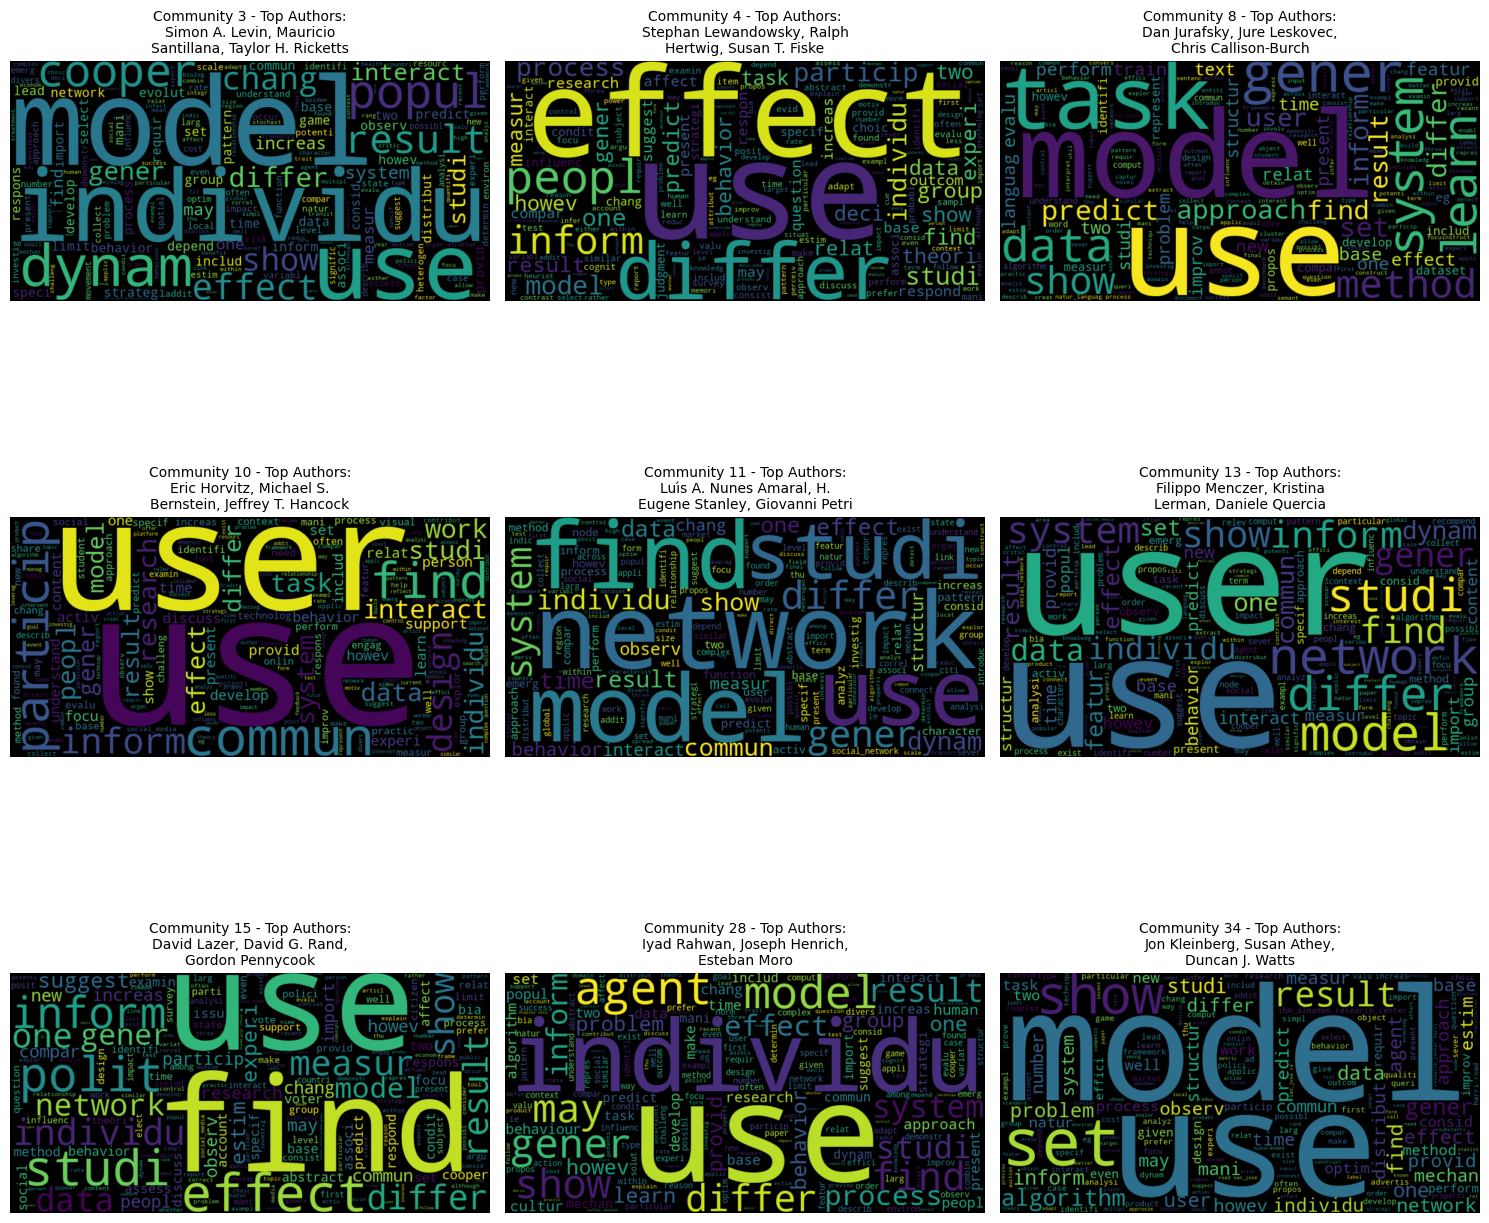

In [288]:
# create the grid for subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # 3x3 grid for 9 communities

# flatten axes for easy iteration
axes = axes.flatten()

# generate and print top 3 authors for each community
for i, (community, group) in enumerate(top_3_authors.groupby("community")):
    print(f"Community {community} - Top 3 authors by degree:")
    print(group[["display_name", "degree"]])

    # generate word cloud for this particular community
    generate_wordcloud_for_community(axes[i], df_top_9_comms, community, top_3_authors)


plt.tight_layout()
plt.show()

Comment on your results. What can you conclude on the different sub-communities in Computational Social Science?

The most prominent words across all sub-communities include "use", "model", "find", "effect", "network", "study", and "individual", suggesting that computational social scientists frequently engage with modeling, understanding effects and interactions, and analyzing networks and individual behaviors.

Some conclusions we could draw are:

- There is a clear division between behavioral and cognitive-focused sub-communities (e.g., Community 4, Community 15) and network, algorithmic, and modeling-focused sub-communities (e.g., Community 11, Community 34).
- Some groups focus on misinformation, human-computer interaction, and decision-making (e.g., Communities 10, 13, 15), while others work on network effects and large-scale computational models (e.g., Communities 11, 28, 34).




Look up online the top author in each community. In light of your search, do your results make sense?

Some examples for the communities are given below.

Community 3, top author is Simon A. Levin who is an ecologist, so it makes sense that the word cloud includes words like "model", "population", "behaviour", aligning with Levin's ecological and environmental research areas. Furthermore, this also makes sense when we look at the list of top 10 TF-IDF words for this community: ['cooper', 'popul', 'influenza', 'individu', 'dynam', 'transmiss', 'speci', 'epidem', 'model', 'leprosi'].

Community 4, top author is Stephan Lewandowsky who is a psychologist. The frequent occurrence of words such as "effect," "use," "different," and "information" indicates an emphasis on cognitive processes, decision-making, and behavioral effects, corresponding with the psychological expertise of the author.

Community 8, top author is Dan Jurafsky who is a computational linguist. The prevalence of terms like "task," "model," "use," and "predict" reflects a focus on natural language processing and machine learning applications in social science.

Community 10, top author is Eric Horvitz who is a computer scientist. The emphasis on words such as "user," "use," and "find" suggests a concentration on human-computer interaction and user behavior analysis, aligning with Horvitz's computer science background.

Community 11, top author is Luís A. Nunes Amaral who is a physicist. The prominence of terms like "find," "system,", "observe" and "studi" indicates a focus on studies regarding systems, which aligns with Amaral's physics background in experimentation, etc.

The top authors in the rest of the communities have interests in computor science, information technology and similar areas, which have applications in many different fields. Hence, their research areas also align with the results. 


### Exercise 3: Computational Social Science

Go back to Week 1, Exercise 1. Revise what you wrote on the topics in Computational Social Science.
In light of your data-driven analysis, has your understanding of the field changed? How?

Initially, we viewed CSS as primarily data-driven social science. Now, we've seen that CSS integrates multiple disciplines: psychology, political science, physics, linguistics, AI, and economics all contribute distinct perspectives. The word cloud and author analysis highlight how different fields bring unique methodologies (e.g., machine learning for text analysis, percolation theory for networks).

Our analysis has reinforced that network science is a core pillar of CSS, connecting disciplines like physics and sociology. Initially, we just thought of networks as just a tool for visualizing relationships, but now we can see how network structures influence phenomena like diffusion, cooperation, and misinformation spread.

Instead of thinking of CSS as a single domain, we can now recognize distinct subfields—some more focused on computational modeling (e.g., network science), while others apply computational tools to study human behavior (e.g., misinformation in political science). The existence of topic clusters, such as human-computer interaction, AI-driven models, and social network dynamics, suggests that CSS is not just about data science but about understanding complex systems through computation.